In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import netCDF4 as nc

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Prepare model

In [2]:
coarse_factors = [32]
Directory = f"data"

variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

len_samples = nz*len(variables)
len_in = nz*(len(variables)-1)
len_out = nz

In [3]:
model_number = 11

train_times = pd.read_csv(Directory+f'/test_train_times/times_train_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(Directory+f'/test_train_times/times_test_{model_number}.csv').drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
print(train_times)
print(test_times)

[49  5 33 54 26  8 17 46 20 60 57 13 31  7 11  3 62  9 56  1 44 32 52 35
 22 58 24 47 55 42 23  2 14 27 43 10 21 34 59 45 51  4 41 29 25 18 53 19
 28]
[12 36 37 50 40 16 48 38  6 39 15 61 30]


In [4]:
input_train, output_train, input_test, output_test = utils.make_train_test_ds(coarse_factors, len_in, train_times, test_times, Directory)

## LRP one alt

In [29]:
class DNN(nn.Module):
    def __init__(self, batch_size, input_size, output_size, drop_prob1=0.2, drop_prob2=0.3, drop_prob3=0.4, hidden_size1=1024, hidden_size2=512, hidden_size3=256):
        super(DNN, self).__init__()
        self.regression = nn.Sequential(nn.Linear(input_size, hidden_size1),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob1),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob2),
                                        nn.Linear(hidden_size2, hidden_size3),
                                        nn.ReLU(),
                                        nn.Dropout(drop_prob3),
                                        nn.Linear(hidden_size3, output_size)
                                        )
        self.drop_prob1 = drop_prob1
        self.drop_prob2 = drop_prob2
        self.drop_prob3 = drop_prob3
        self.batch_size = batch_size
        self.input_shape = input_size
        self.output_shape = output_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3

    
    def forward(self, x):
        return self.regression(x)

### Load model

In [30]:
learning_rate = 0.001
batch_size = 16
nb_epochs = 20
train_losses=[]
test_losses=[]

model_load = DNN(batch_size=batch_size,input_size=len_in+1,output_size=1)
model_load.load_state_dict(torch.load(f'explo/models/simple_dnn_one_alt_3'))
#model_load.eval()

<All keys matched successfully>

### LRP

In [31]:
X = input_test[1000]

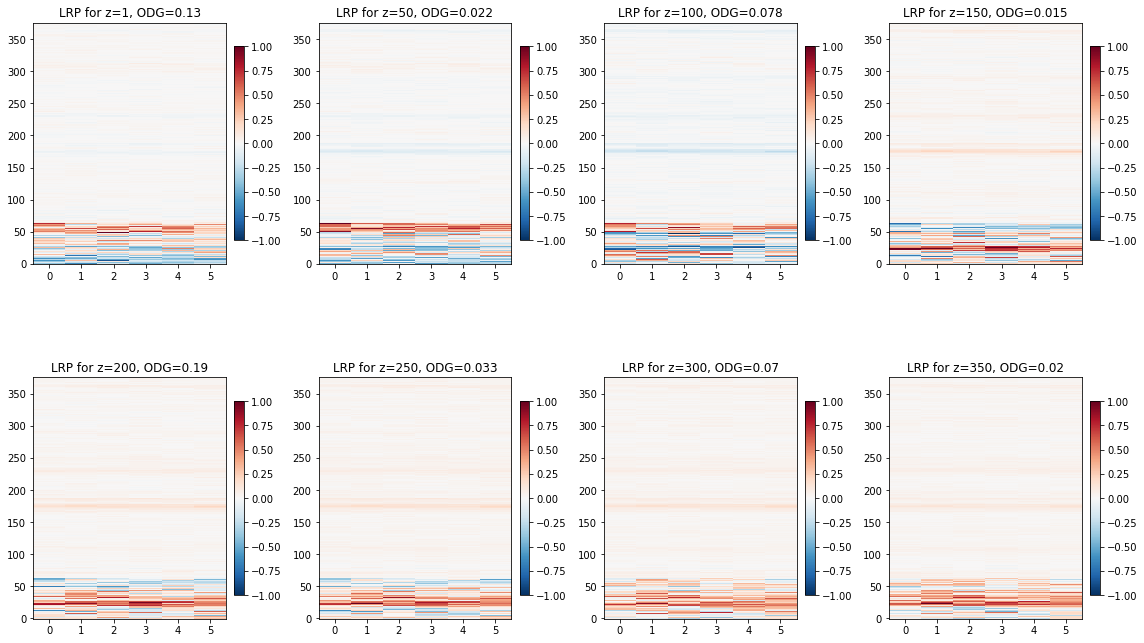

In [32]:
Z = [1,50,100,150,200,250,300,350]
fig,axes = plt.subplots(2,4,figsize=(16,10))
Z_ds = []
odg = []
for i in range(len(Z)):
    Z_ds.append(utils.lrp(model_load, X, Z[i]))
    odg.append(np.abs(Z_ds[i]).max())

im00 = axes[0,0].imshow(Z_ds[0]/np.abs(Z_ds[0]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im00, ax=axes[0,0], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,0].set_title("LRP for z={}, ODG={:.2}".format(Z[0],odg[0]))

im01 = axes[0,1].imshow(Z_ds[1]/np.abs(Z_ds[1]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im01, ax=axes[0,1], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,1].set_title("LRP for z={}, ODG={:.2}".format(Z[1],odg[1]))

im02 = axes[0,2].imshow(Z_ds[2]/np.abs(Z_ds[2]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im02, ax=axes[0,2], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,2].set_title("LRP for z={}, ODG={:.2}".format(Z[2],odg[2]))

im03 = axes[0,3].imshow(Z_ds[3]/np.abs(Z_ds[3]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im03, ax=axes[0,3], orientation='vertical', fraction=0.046, pad=0.04)
axes[0,3].set_title("LRP for z={}, ODG={:.2}".format(Z[3],odg[3]))

im10 = axes[1,0].imshow(Z_ds[4]/np.abs(Z_ds[4]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im10, ax=axes[1,0], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,0].set_title("LRP for z={}, ODG={:.2}".format(Z[4],odg[4]))

im11 = axes[1,1].imshow(Z_ds[5]/np.abs(Z_ds[5]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im11, ax=axes[1,1], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,1].set_title("LRP for z={}, ODG={:.2}".format(Z[5],odg[5]))

im12 = axes[1,2].imshow(Z_ds[6]/np.abs(Z_ds[6]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im12, ax=axes[1,2], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,2].set_title("LRP for z={}, ODG={:.2}".format(Z[6],odg[6]))

im13 = axes[1,3].imshow(Z_ds[7]/np.abs(Z_ds[7]).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
fig.colorbar(im13, ax=axes[1,3], orientation='vertical', fraction=0.046, pad=0.04)
axes[1,3].set_title("LRP for z={}, ODG={:.2}".format(Z[7],odg[7]))

fig.tight_layout()
plt.show()

## LRP whole BL

### Load model

In [33]:
learning_rate = 0.001
batch_size = 16
nb_epochs = 20
train_losses=[]
test_losses=[]

model_load = DNN(batch_size=batch_size,input_size=len_in,output_size=len_out)
model_load.load_state_dict(torch.load(f'explo/models/simple_dnn11'))

<All keys matched successfully>

Text(0.5, 1.0, 'LRP for whole pred, ODG=0.13')

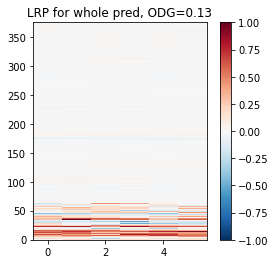

In [39]:
X = input_test[200]
ds = utils.lrp(model_load, X, z=1, one_alt=False)

im = plt.imshow(ds/np.abs(ds).max() , origin='lower', cmap = 'RdBu_r' , interpolation = 'nearest', aspect=0.02, vmin=-1, vmax=1)
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.title("LRP for whole pred, ODG={:.2}".format(odg[0]))

## LRP AE

In [2]:
# AE model
class AE(nn.Module):
    def __init__(self, input_features=376,  hidden_size1=256, hidden_size2=128, z_dim=3, 
                drop_enc1=0.3, drop_enc2=0.2, drop_enc3=0.3, 
                drop_dec1 = 0.3, drop_dec2=0.2, drop_dec3=0.2):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(nn.BatchNorm1d(input_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_enc1),
                                        nn.Linear(input_features, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_enc2),
                                        nn.Linear(hidden_size1, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_enc3),
                                        nn.Linear(hidden_size2, z_dim))
        self.decoder = nn.Sequential(nn.BatchNorm1d(z_dim, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_dec1),
                                        nn.Linear(z_dim, hidden_size2),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_dec2),
                                        nn.Linear(hidden_size2, hidden_size1),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(hidden_size1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(drop_dec3),
                                        nn.Linear(hidden_size1, input_features))

        
    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

### Prepare data

In [5]:
coarse_factors = [32]
Directory = f"data"
variables=['u', 'v', 'w', 'theta', 's', 'tke', 'wtheta']
nz=376

full_len_in = nz*(len(variables)-1)
len_in = nz

model_number = 11
tmin=1
tmax=62+1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print('using cuda : ', torch.cuda.is_available())

path_times_train = f'data/test_train_times/times_train_{model_number}.csv'
path_times_test = f'data/test_train_times/times_test_{model_number}.csv'
isFile = os.path.isfile(path_times_train) and os.path.isfile(path_times_test)
#print(isFile)

if not isFile :
    utils.split_times(tmin,tmax,model_number)
    
train_times = pd.read_csv(path_times_train).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]
test_times = pd.read_csv(path_times_test).drop(columns=['Unnamed: 0']).to_numpy().transpose()[0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_, _, input_test, _ = utils.make_train_test_ds(coarse_factors, full_len_in, train_times, test_times, Directory)
input_test = input_test.reshape(-1,len(variables)-1,nz)

for i in range(len(variables)-1):
    input_test[:,i] -= torch.mean(input_test[:,i])
    input_test[:,i] /= torch.std(input_test[:,i])

In [34]:
var = 0     # u=0, v=1, w=2, theta=3, s=4, tke=5, wtheta=6
X = input_test[:,var]
samples = [10,301,1000]
ds = []
for sample in samples:
    ae_model = AE(input_features=nz)
    ae_model.load_state_dict(torch.load('explo/models/{}_ae_net.pt'.format(variables[0]), map_location=torch.device(device)))
    ae_model.to(device)
    for params in ae_model.parameters():
        params.requires_grad = False

    ds.append(utils.lrp(ae_model, X, sample=sample, one_alt=False))

max : 136422670.0 , min : -63580012.0 , mean : -37850356.0


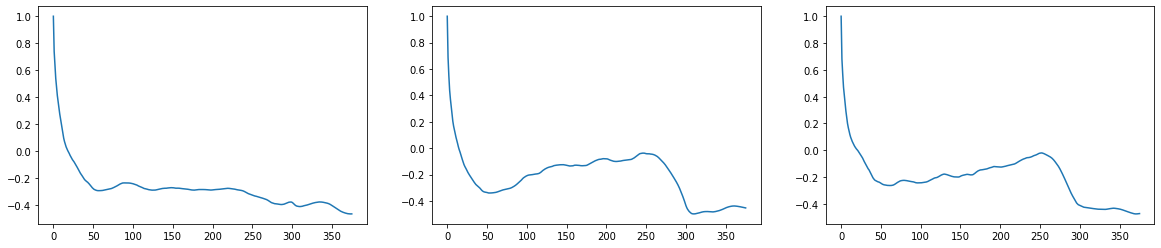

In [35]:
print('max :',ds[0].max(), ', min :',ds[0].min(), ', mean :',ds[0].mean())

fig,axes = plt.subplots(1,len(samples),figsize=(20,4))

for i in range(len(samples)):
    try :
        axes[i].plot(ds[i]/ds[i].max(), label="train")
    except :
        pass